In [172]:
#sqlite to csv cited from https://www.kaggle.com/code/zhouhong0/sqlite-to-csv
import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  classification_report



In [173]:
# read switrs.sqlite.zip database into pandas dataframe
con = sqlite3.connect('switrs.sqlite')
cur = con.cursor()
# Query the database for collisions table
victims_query = " SELECT * FROM victims WHERE case_id IN \
(SELECT case_id FROM collisions WHERE motorcycle_collision == 1)"
# Read the data
victims = pd.read_sql_query(victims_query, con)
# select 10000 rows randomly
victims = victims.sample(n=10000, random_state=1)
# save victims data
victims.to_csv('victims.csv', index=False)

In [174]:
#read victims data
data = pd.read_csv('victims.csv')
display(data.head())
display(data.describe())
print(data.info())

,id,case_id,party_number,victim_role,victim_sex,victim_age,victim_degree_of_injury,victim_seating_position,victim_safety_equipment_1,victim_safety_equipment_2,victim_ejected
0,2843841,2730277,1,2,female,54.0,killed,2.0,P,Y,1.0
1,3158878,3027346,3,1,male,49.0,complaint of pain,1.0,P,W,1.0
2,8619911,9365010617153010198,1,1,male,50.0,other visible injury,1.0,W,NaN,2.0
3,5283048,91168150,1,1,male,40.0,5,1.0,P,W,0.0
4,4417930,8949648,1,1,male,64.0,other visible injury,9.0,N,P,0.0


,id,case_id,party_number,victim_role,victim_age,victim_seating_position,victim_ejected
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,9829.000000,9991.000000,9969.000000
mean,2.748594e+06,2.370953e+17,1.469600,1.335400,35.069590,1.900110,0.746213
std,1.720892e+06,1.355294e+18,0.620415,0.666147,16.250677,1.850961,0.814441
min,8.000000e+02,2.895000e+03,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.383196e+06,3.292340e+06,1.000000,1.000000,23.000000,1.000000,0.000000
50%,2.675864e+06,5.668020e+06,1.000000,1.000000,32.000000,1.000000,1.000000
75%,3.884944e+06,8.535046e+06,2.000000,2.000000,47.000000,2.000000,1.000000
max,8.816802e+06,9.865011e+18,14.000000,6.000000,119.000000,9.000000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   case_id                    10000 non-null  uint64 
 2   party_number               10000 non-null  int64  
 3   victim_role                10000 non-null  int64  
 4   victim_sex                 9806 non-null   object 
 5   victim_age                 9829 non-null   float64
 6   victim_degree_of_injury    10000 non-null  object 
 7   victim_seating_position    9991 non-null   float64
 8   victim_safety_equipment_1  9557 non-null   object 
 9   victim_safety_equipment_2  7583 non-null   object 
 10  victim_ejected             9969 non-null   float64
dtypes: float64(3), int64(3), object(4), uint64(1)
memory usage: 859.5+ KB
None


In [175]:
#check data consistency
check_num_str = ['party_number','victim_seating_position','victim_ejected','party_number','victim_role']
for i in check_num_str:
    print(i,':',data[i].unique())
print("-"*100)
for col in data.columns:
    if data[col].dtype == 'object':
        print(col,':',data[col].unique())

party_number : [ 1  3  2  5 14  4  6  8]
victim_seating_position : [ 2.  1.  9.  3.  0.  6.  4.  5.  7.  8. nan]
victim_ejected : [ 1.  2.  0.  3. nan]
party_number : [ 1  3  2  5 14  4  6  8]
victim_role : [2 1 3 6 4 5]
----------------------------------------------------------------------------------------------------
victim_sex : ['female' 'male' nan '4']
victim_degree_of_injury : ['killed' 'complaint of pain' 'other visible injury' '5' 'no injury'
 'severe injury' '7' '6']
victim_safety_equipment_1 : ['P' 'W' 'N' 'M' 'L' nan 'Y' 'A' 'K' 'Q' 'G' 'V' 'B' 'D' 'H' 'J' 'C' 'E'
 'X' 'T' 'F']
victim_safety_equipment_2 : ['Y' 'W' nan 'P' 'G' 'M' 'Q' 'V' 'H' 'A' 'X' 'F' 'T' 'B' 'C' 'L' 'N' 'K'
 'J' 'E' 'U' 'D' 'R']


In [176]:
#  Change the value of victim_ejected attribute in victims that is not [0,1] to none
data["victim_ejected"] = data["victim_ejected"].apply(lambda x: np.nan if x not in [0,1] else x)
#  Change the value of victim_sex attribute in data that is not female or male to none
data["victim_sex"] = data["victim_sex"].apply(lambda x: np.nan if x not in ['female','male'] else x)
# Change the value of victim_degree_of_injury attribute in data that is not killed, complaint of pain, other visible injury, severe injury, no injured to none
data["victim_degree_of_injury"] = data["victim_degree_of_injury"].apply(lambda x: np.nan if x not in ['killed','complaint of pain','other visible injury','severe injury','no injury'] else x)
#  If 'killed' or 'severe injury' is converted to 'Killed or Severely Injured'
data["victim_degree_of_injury"] = data["victim_degree_of_injury"].apply(lambda x: 'Killed or Severely Injured' if x in ['killed','severe injury'] else x)
#  If it is 'complaint of pain' or 'other visible injury', it is converted to 'other visible injury'
data["victim_degree_of_injury"] = data["victim_degree_of_injury"].apply(lambda x: 'other visible injury' if x in ['complaint of pain','other visible injury'] else x)
# Missing value processing
data.dropna(inplace=True)


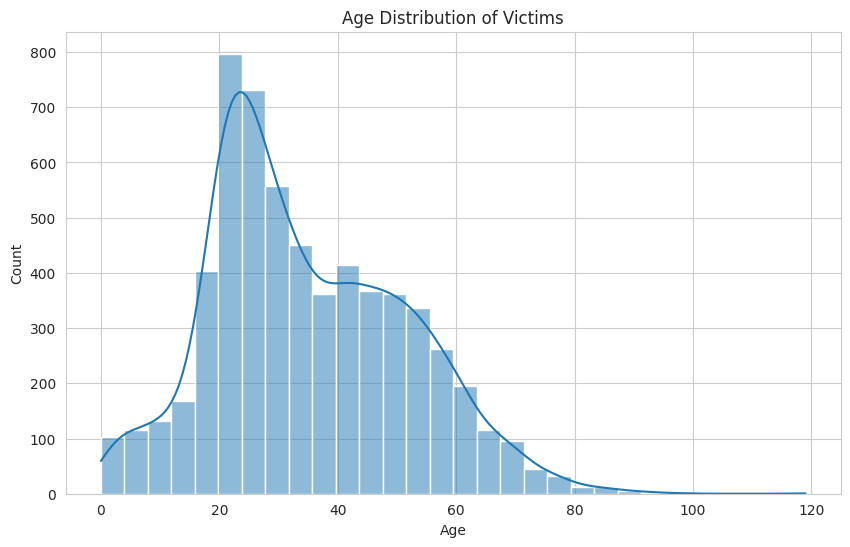

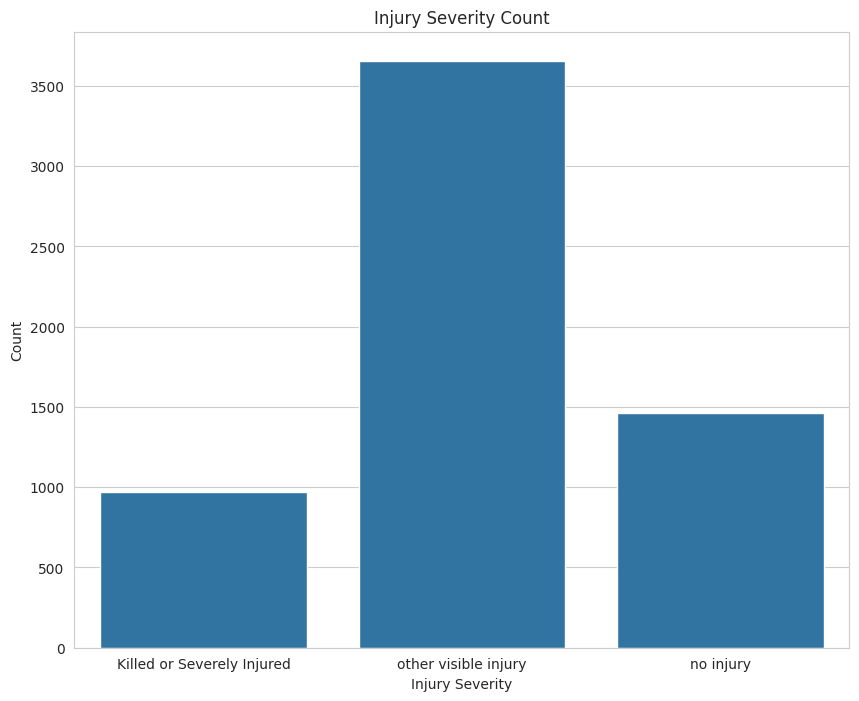

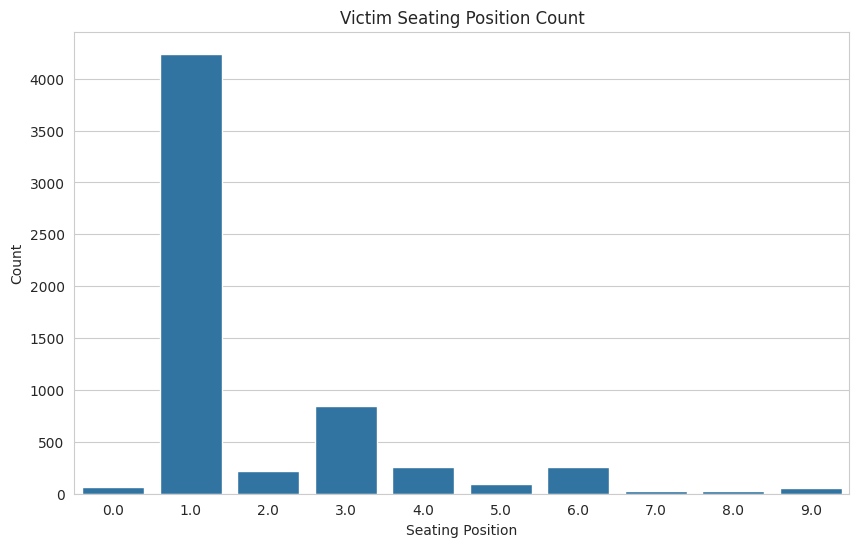

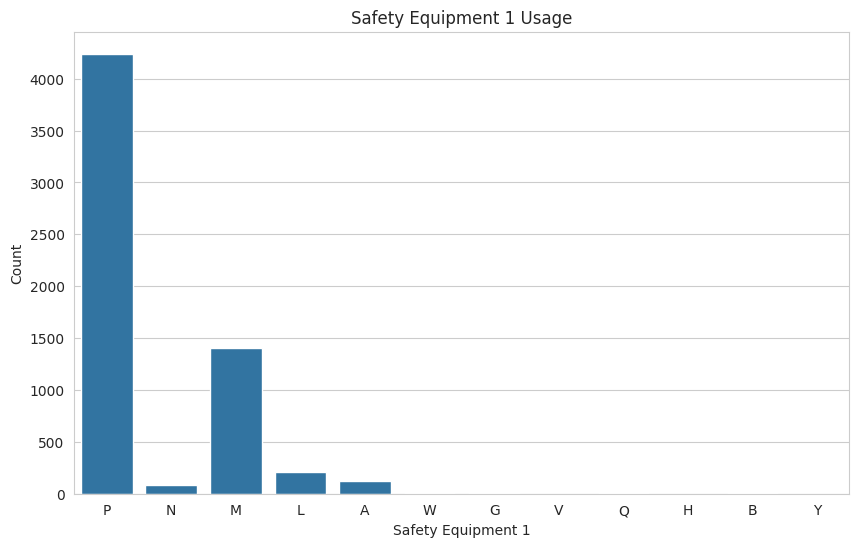

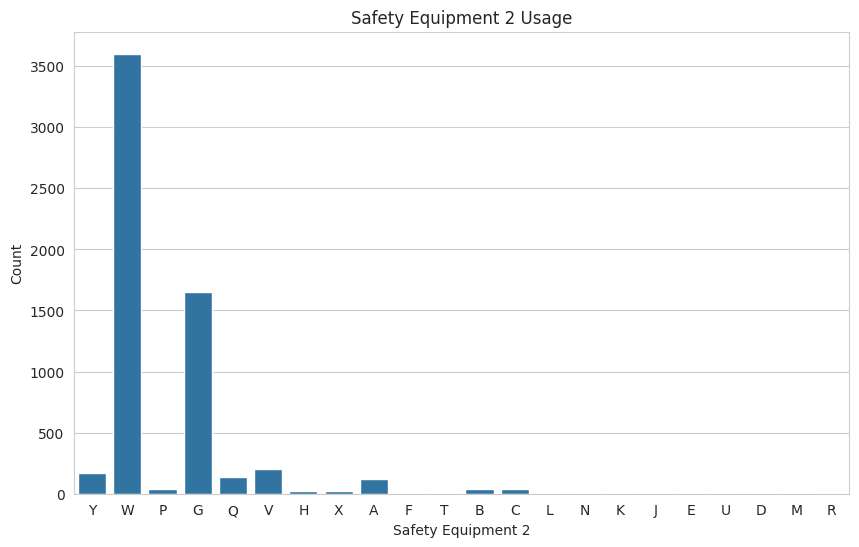

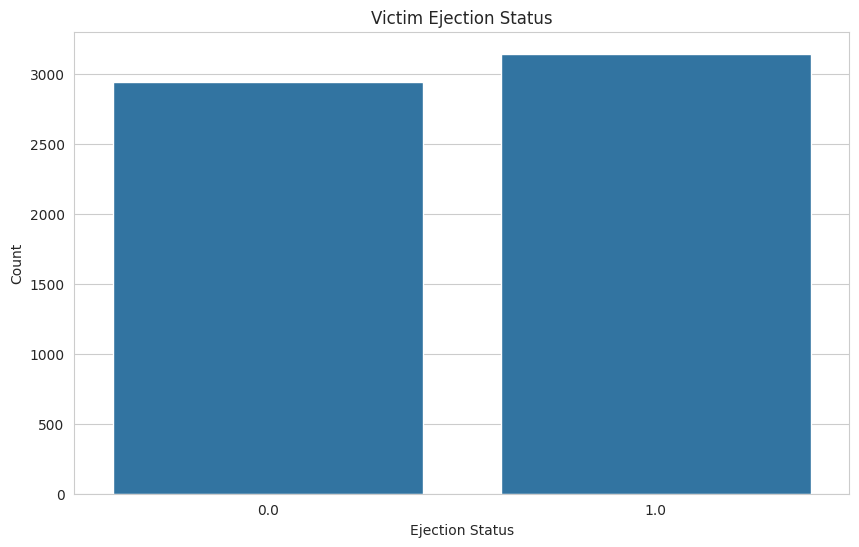

In [177]:

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting different aspects of the data to understand it better
# Age distribution of victims
plt.figure(figsize=(10, 6))
sns.histplot(data['victim_age'], kde=True, bins=30)
plt.title('Age Distribution of Victims')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Injury severity count
plt.figure(figsize=(10, 8))
sns.countplot(data=data, x='victim_degree_of_injury')
plt.title('Injury Severity Count')
plt.xlabel('Injury Severity')
plt.ylabel('Count')
plt.show()

# Seating position count
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='victim_seating_position')
plt.title('Victim Seating Position Count')
plt.xlabel('Seating Position')
plt.ylabel('Count')
plt.show()

# Safety equipment 1 usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='victim_safety_equipment_1')
plt.title('Safety Equipment 1 Usage')
plt.xlabel('Safety Equipment 1')
plt.ylabel('Count')
plt.show()

# Safety equipment 2 usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='victim_safety_equipment_2')
plt.title('Safety Equipment 2 Usage')
plt.xlabel('Safety Equipment 2')
plt.ylabel('Count')
plt.show()

# Ejection status
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='victim_ejected')
plt.title('Victim Ejection Status')
plt.xlabel('Ejection Status')
plt.ylabel('Count')
plt.show()


In [178]:
np.unique(data['victim_degree_of_injury'])

array(['Killed or Severely Injured', 'no injury', 'other visible injury'],
      dtype=object)

In [179]:
#  Convert object type data to numerical type
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category').cat.codes

In [180]:

X = data.drop(['victim_degree_of_injury','id','case_id'], axis=1)
y = data['victim_degree_of_injury']
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#  Data standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [181]:
# Initialize the models
LogisticRegression_reg = LogisticRegression()
svc_reg = SVC()
KNeighborsClassifier_reg =  KNeighborsClassifier(n_neighbors = 3)
linear_svc = LinearSVC()
decision_tree_reg = DecisionTreeClassifier()
random_forest_reg = RandomForestClassifier(n_estimators=100)

# Train the models
LogisticRegression_reg.fit(X_train, y_train)
svc_reg.fit(X_train, y_train)
KNeighborsClassifier_reg.fit(X_train, y_train)
linear_svc.fit(X_train, y_train)
decision_tree_reg.fit(X_train, y_train)
random_forest_reg.fit(X_train, y_train)

/home/mjcwkq/program/order/python/berkeley_data_mining/final_pro/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mjcwkq/program/order/python/berkeley_data_mining/final_pro/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomForestClassifier()

In [182]:
# Make predictions using the trained models
LogisticRegression_reg_preds = LogisticRegression_reg.predict(X_test)
svc_reg_preds = svc_reg.predict(X_test)
KNeighborsClassifier_reg_preds = KNeighborsClassifier_reg.predict(X_test)
linear_svc_reg_preds = linear_svc.predict(X_test)
decision_tree_reg_preds = decision_tree_reg.predict(X_test)
random_forest_reg_preds = random_forest_reg.predict(X_test)

In [183]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'Logistic Regression': LogisticRegression_reg_preds,
    'Support Vector Machines': svc_reg_preds,
    'KNN': KNeighborsClassifier_reg_preds,
    'Linear SVC': linear_svc_reg_preds,
    'Decision Tree': decision_tree_reg_preds,
    'Random Forest': random_forest_reg_preds
})

In [184]:
#  Select the value with the most occurrences in predictions_df as the final prediction result. If there are multiple values with the same number of occurrences, randomly select one

predictions = predictions_df.mode(axis=1)[0]

evaluation_report = classification_report(y_test, predictions)
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.39      0.08      0.13       188
           1       0.93      0.99      0.96       301
           2       0.79      0.94      0.86       728

    accuracy                           0.82      1217
   macro avg       0.70      0.67      0.65      1217
weighted avg       0.77      0.82      0.77      1217

